# **💎 Project 0: Age Estimation ⌛️**
Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

<div> <img src="https://howsam.org/wp-content/uploads/2023/08/deep-catalyst-800-400x229.gif" alt="Drawing" style="width: 400px;"/></div>

# 🔴 **Import Libs**

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=2267569517d886401f207ef2526d4b46bd3a8c62083ecc0cb3262e7350ddbc44
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
import PIL
from PIL import Image
#import face_recognition

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid

import tqdm
from tqdm.notebook import tqdm
import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
cv2 --> 4.8.0
PIL --> 9.4.0
sklearn --> 1.2.2
torch --> 2.0.1+cu118
torchvision --> 0.15.2+cu118
torchmetrics --> 1.1.2


# 🔴 **Utils**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Copy & Unzip the Dataset**

In [ ]:
os.mkdir('/content/Dataset')

In [ ]:
!tar -xzf '/content/drive/MyDrive/UTK/UTKFace.tar.gz' -C '/content/Dataset'

* x: This flag stands for "extract". It tells the tar command to extract the files from the archive.

* v: This flag stands for "verbose". It displays the list of files being extracted in the terminal.

* z: This flag indicates that the archive file is compressed using gzip.

* f: This flag indicates that the following argument is the name of the archive file.

## 🟠 EDA

### 🟡 Let's explore the images in the UTK dataset together!

🔰 Download the UFTK dataset to your computer:


*   explore it
*   then list five observations or interesting characteristics you find in the dataset.



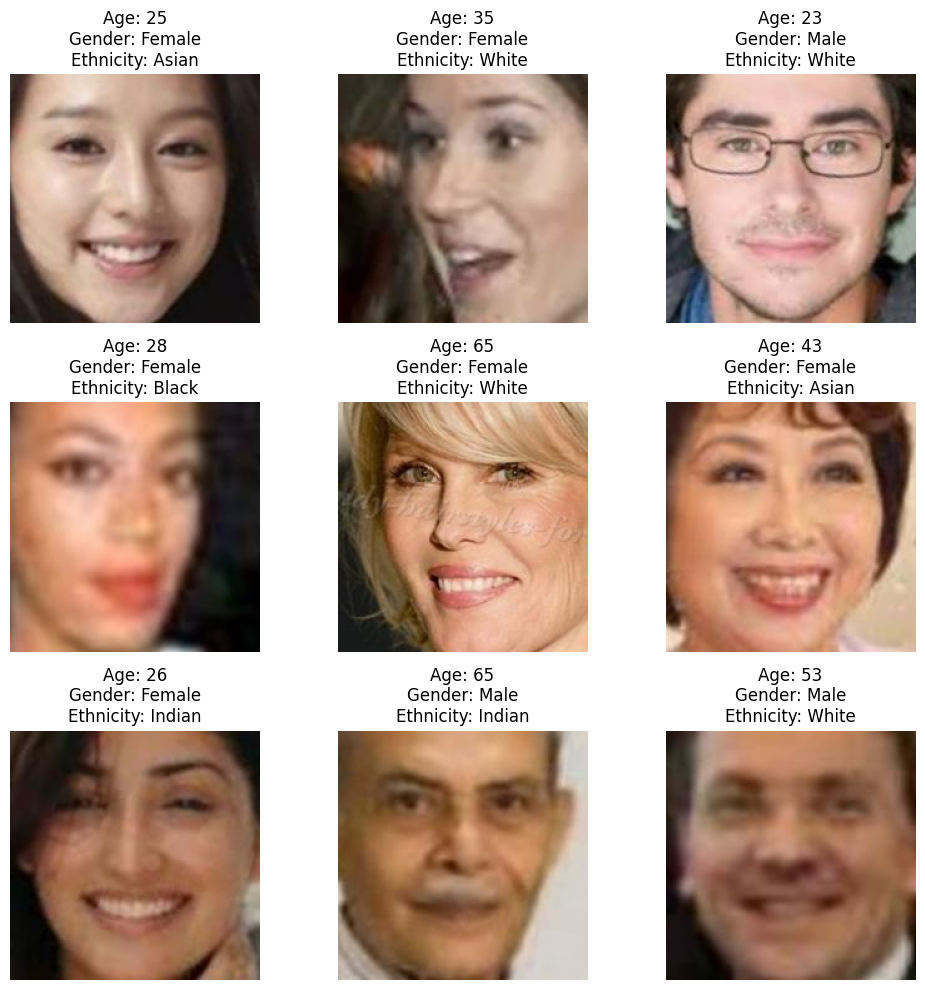

In [ ]:
# Replace with the actual path to your UTK dataset images folder
dataset_folder = '/content/Dataset/UTKFace'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()


### 🟡 Create a csv file which contains labels

🔰 During this session, your mission is to:
   

*   create the following DataFrame
*   and save it as a CSV file named 'utkface_dataset.csv'


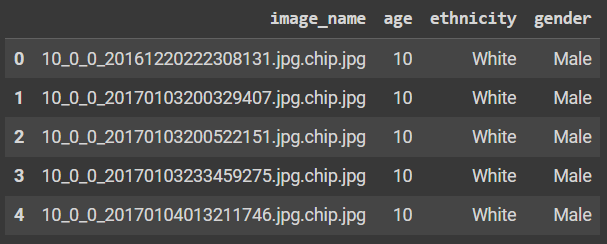

In [ ]:
image_files = os.listdir(dataset_folder)
#age, gender, ethnicity = img_files[0:].split('_')[0:3]

image_files = np.array(image_files)
age =[]
gender = []
ethnicity = []

for idx, img_path in enumerate(image_files,1):
    age.append(int(img_path.split('_')[0]))
    gender.append(int(img_path.split('_')[1]))
    ethnicity.append((img_path.split('_')[2]))


age = np.array(age)
genders = np.array([ "Male" if x == 0 else 'Female'for x in gender])
ethnicity = np.array(ethnicity)

print(len(age),len(gender),len(ethnicity),len(image_files))

print(np.unique(age))

print(np.unique(genders))

print(np.unique(ethnicity))




def eth_corrector(X:str):

  if X.isdigit():
    return ['White', 'Black', 'Asian', 'Indian', 'Others'][int(X)]
  else:
    return np.nan

ethnicity = np.array([eth_corrector(x.split('_')[2]) for x in image_files])
print(np.unique(ethnicity))

23708 23708 23708 23708
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 103 105 110 111 115 116]
['Female' 'Male']
['0' '1' '2' '20170109142408075.jpg.chip.jpg'
 '20170109150557335.jpg.chip.jpg' '20170116174525125.jpg.chip.jpg' '3' '4']
['Asian' 'Black' 'Indian' 'Others' 'White' 'nan']


In [ ]:
df = pd.DataFrame({'image_name': image_files, 'age': age, 'ethnicity': ethnicity, 'gender': genders})
df

,image_name,age,ethnicity,gender
0,58_0_0_20170111204009616.jpg.chip.jpg,58,White,Male
1,58_1_1_20170117194028702.jpg.chip.jpg,58,Black,Female
2,1_1_0_20170109190936410.jpg.chip.jpg,1,White,Female
3,89_1_0_20170120230445570.jpg.chip.jpg,89,White,Female
4,31_0_2_20161219192759515.jpg.chip.jpg,31,Asian,Male
...,...,...,...,...
23703,29_1_0_20170104192921991.jpg.chip.jpg,29,White,Female
23704,1_1_0_20170110212607474.jpg.chip.jpg,1,White,Female
23705,40_0_3_20170119192039721.jpg.chip.jpg,40,Indian,Male
23706,14_1_3_20170104221901782.jpg.chip.jpg,14,Indian,Female


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  23708 non-null  object
 1   age         23708 non-null  int64 
 2   ethnicity   23708 non-null  object
 3   gender      23708 non-null  object
dtypes: int64(1), object(3)
memory usage: 741.0+ KB


In [ ]:
df.drop(df[df['ethnicity'] == 'nan'].index, inplace = True)

In [ ]:
df['age'] = df['age'].astype('float64')

In [ ]:
df[['image_name', 'ethnicity', 'gender']] = df[['image_name', 'ethnicity', 'gender']].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   image_name  23705 non-null  category
 1   age         23705 non-null  float64 
 2   ethnicity   23705 non-null  category
 3   gender      23705 non-null  category
dtypes: category(3), float64(1)
memory usage: 1.1 MB


In [ ]:
df['ethnicity'].unique()

['White', 'Black', 'Asian', 'Indian', 'Others']
Categories (5, object): ['Asian', 'Black', 'Indian', 'Others', 'White']

In [ ]:
df.isnull().sum().sum()


0

### 🟡 Plot histogram for age

<Axes: xlabel='age', ylabel='Count'>

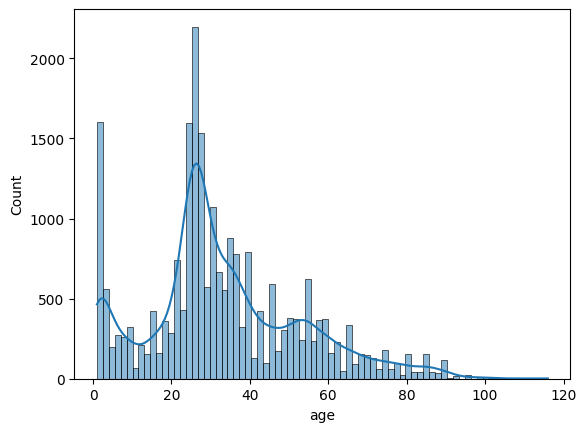

In [ ]:
sns.histplot(data = df, x = "age",kde = True)

#### 🛑 **Tip:** You can use Plotly or Seaborn libraries to create visually appealing plots!

### 🟡 Plot histogram for gender

<Axes: xlabel='gender', ylabel='Count'>

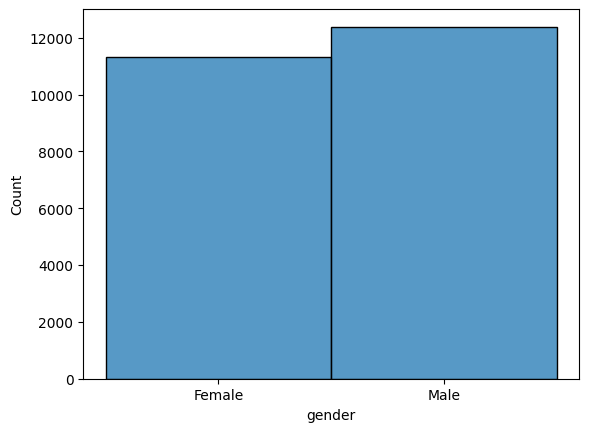

In [ ]:
sns.histplot(data= df, x = 'gender')

### 🟡 Plot histogram for ethnicity

<Axes: xlabel='ethnicity', ylabel='Count'>

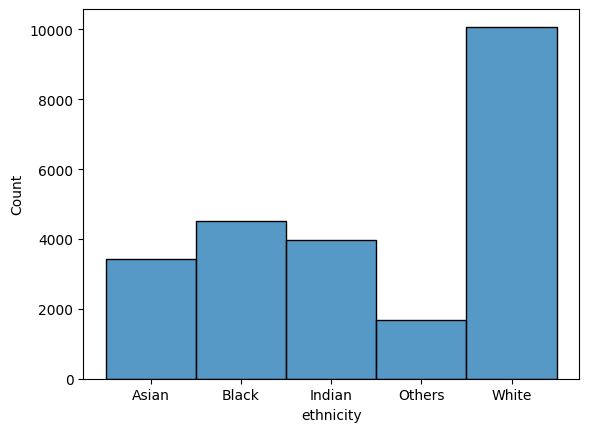

In [ ]:
sns.histplot(data= df, x = 'ethnicity')

### 🟡 Calculate the cross-tabulation of gender and ethnicity using the pandas.crosstab() function.

In [ ]:
pd.crosstab(index= df['gender'], columns= df['ethnicity'])

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1859,2208,1714,932,4601
Male,1575,2318,2261,760,5477


### 🟡 Create violin plots and box plots for age, separately for men and women.

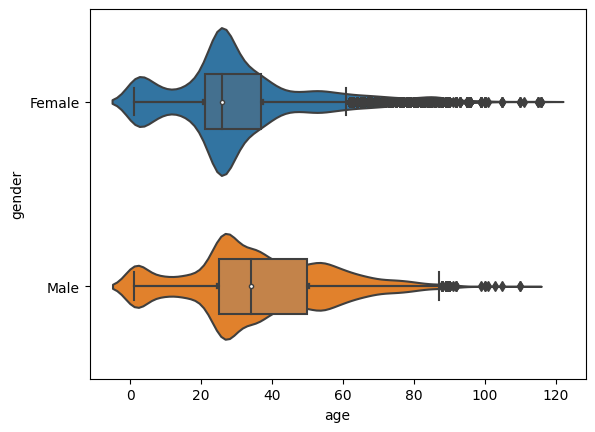

In [ ]:
ax = sns.violinplot(data = df, x = 'age', y = 'gender')
sns.boxplot(data = df, x = 'age', y = 'gender', saturation= 0.5, width= 0.3,
            boxprops={'zorder': 2}, ax=ax)
plt.show()

### 🟡 Create violin plots and box plots for age, separately for each ethnicity.

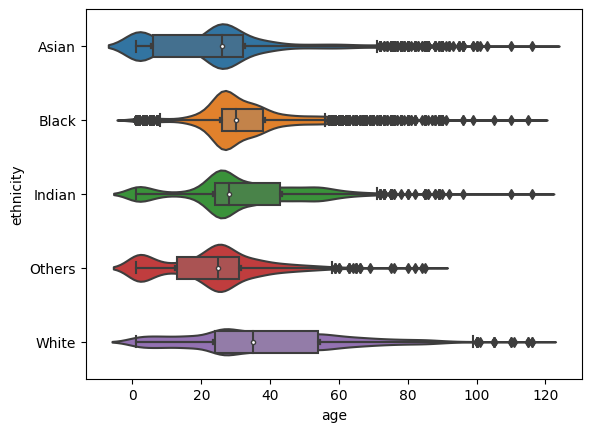

In [ ]:
ax = sns.violinplot(data = df, x = 'age', y = 'ethnicity')
sns.boxplot(data = df, x = 'age', y = 'ethnicity', saturation= 0.5, width= 0.3,
            boxprops={'zorder': 2}, ax=ax)
plt.show()

## 🟠 Split datasets

🔰 During this session, your task is to use scikit-learn's train_test_split function to partition the dataset into training, validation, and test sets.

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)
df_test, df_valid = train_test_split(df_test, test_size = 0.5, random_state = 42)

In [ ]:
df_train.shape,df_valid.shape, df_test.shape

((16593, 4), (3556, 4), (3556, 4))

###🟡 Plot histograms for age in the training, validation, and test sets.

⛔️ **Warning:** Ensure that the distributions of the training, validation, and test sets are similar.

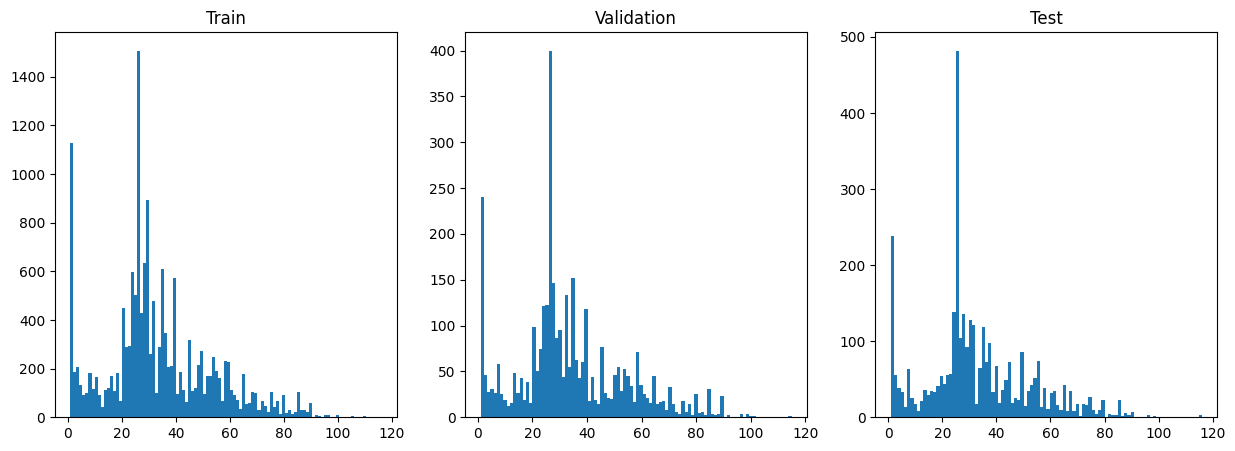

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

### 🟡 Save the training, validation, and test sets in separate CSV files.

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## 🟠 Define transformations

🔰 During this session, your mission is to implement a data transformation pipeline using PyTorch's transforms.
The transformations should include:

*   Resizing images to a resolution of 128x128 pixels.
*   Applying random horizontal flips to the images.
*   Introducing random rotations of 15 degrees.
*   Adjusting image color using the ColorJitter transformation.
*   Converting the images to tensors.
*   Normalizing the pixel values using the provided mean and standard deviation values `(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.

In [ ]:
transform_train = transforms.Compose([transforms.Resize(size= (128,128)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ColorJitter(brightness = 0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                                           std = (0.229, 0.224, 0.225))])

transform_test = transforms.Compose([transforms.Resize(size= (128,128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                                           std = (0.229, 0.224, 0.225))])

## 🟠 Custom dataset

In [ ]:
class UTKDataset(Dataset):

  def __init__(self, root_images, root_data, phase, transform):

    self.transform = transform
    root_csv = f'{root_data}{phase}_set.csv'
    self.data = pd.read_csv(root_csv)
    image_array = self.data['image_name'].to_numpy()
    self.image_list = [f'{root_images}{file_}' for file_ in image_array]

  def __getitem__(self,idx):

    image_path = self.image_list[idx]
    image = Image.open(image_path).convert("RGB")
    image = self.transform(image)

    age = self.data['age'][idx]
    ethnicity = self.data['ethnicity'][idx]
    gender = self.data['gender'][idx]

    return image, age, gender, ethnicity

  def __len__(self):
    return len(self.data)

🔰 Utilize the UTKDataset class you've created to instantiate dataset objects for the training, validation, and test sets.

In [ ]:
train_set = UTKDataset('/content/Dataset/UTKFace/', '/content/', 'train', transform_train)
valid_set = UTKDataset('/content/Dataset/UTKFace/', '/content/', 'valid', transform_test)
test_set = UTKDataset('/content/Dataset/UTKFace/', '/content/', 'test', transform_test)

len(train_set), len(valid_set), len(test_set)

(16593, 3556, 3556)

In [ ]:
train_set[120][0].shape

torch.Size([3, 128, 128])

🔰 Plot a few images to verify the functionality of the dataset objects.

In [ ]:
image_grid = make_grid(X , nrow = 16, normalize = True).permute(1,2,0)
plt.figure(figsize = (16, 8))
plt.imshow(image_grid)

## 🟠 Define dataloader

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
train_loader = DataLoader(train_set, batch_size = 128, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size = 256, shuffle = False)
test_loader = DataLoader(test_set, batch_size = 256, shuffle = False)

In [ ]:
len(train_loader)

130

🔰 Test the dataloaders using `next(iter())`

In [ ]:
X, y , z, a = next(iter(train_loader))


In [ ]:
print(X.shape)
print(y)
print(z)
print(a)

torch.Size([128, 3, 128, 128])
tensor([35., 45., 26., 31., 68., 36., 27., 33., 19., 53., 29., 25., 34., 35.,
         1., 56., 88., 24., 28., 85.,  7., 27., 35., 24., 22., 28., 34.,  3.,
        22., 56., 21., 40., 22., 66., 55., 26., 26., 70., 30.,  2., 37.,  2.,
        29., 29., 25., 26., 24., 40., 18., 43.,  1., 11., 40., 26., 50., 63.,
        20., 27.,  1.,  1., 25., 26., 24., 26., 26., 30., 24.,  1., 26., 52.,
        35., 86., 35., 11., 42., 32., 24., 25., 28.,  7., 18., 41., 24., 63.,
        28., 45., 54., 16., 16., 15., 22., 56., 42., 23., 35.,  4., 18.,  1.,
        38., 32., 67., 89., 48.,  8., 34., 30., 29., 22., 30., 34., 26., 23.,
        58., 20., 35., 11., 29., 61., 23.,  5., 26., 34., 40., 32., 25., 24.,
        30., 24.], dtype=torch.float64)
('Male', 'Female', 'Male', 'Male', 'Male', 'Female', 'Female', 'Male', 'Male', 'Female', 'Female', 'Female', 'Male', 'Male', 'Male', 'Female', 'Female', 'Female', 'Male', 'Female', 'Female', 'Female', 'Male', 'Female', 'Female'

# 🔴 **Model**

🔰 Use the following template to create a custom model employing the ResNet-50 architecture

🔰🔰 Using without Custom class network

In [ ]:
def resnet_model(resnet_type, resnet_weights, out_features):
  model = resnet_type(weights = resnet_weights)

  linear_in_feature = model.fc.in_features

  model.fc = nn.Linear(linear_in_feature, out_features)

  return model

In [ ]:
model_func = resnet_model(resnet_type = models.resnet34, resnet_weights= models.ResNet34_Weights.IMAGENET1K_V1, out_features = 1)
model_func

In [ ]:
model_func.requires_grad_(False)
i = 0
for layer in reversed(list(model_func.children())):
    layer.requires_grad_(True)
    i += 1

    print(layer)
    if i == 3:
      break


In [ ]:
num_trainable_params(model_func)

13.114881

🔰🔰 Using Custom class Network

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self, resnet_type, resnet_weights, out_features,):

    super().__init__()

    self.model = nn.Sequential(*list(resnet_type(weights = resnet_weights).children())[:-1])


    self.linear = nn.LazyLinear(out_features)


  def forward(self, x):

    y = self.model(x)
    y = self.linear(y.flatten(1))

    return y


🔰 Create an object for model using the AgeEstimationModel class you've created.

In [ ]:
model = AgeEstimationModel(resnet_type = models.resnet34, resnet_weights= models.ResNet34_Weights.IMAGENET1K_V1, out_features = 1)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 66.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AgeEstimationModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
model(torch.randn(1,3,64,64)).shape

torch.Size([1, 1])

In [ ]:
model.requires_grad_(False)
model.linear.requires_grad_(True)
list(model.children())[0][-2].requires_grad_(True)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
num_trainable_params(model)

21.285185

# 🔴 **Config**

🔰 Define the optimizer, loss function, and metrics in this section, and ensure the model is sent to the appropriate device.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
lr = 0.001
wd = 1e-5

batch_size_train = 128
batch_size_validation = 256
batch_size_test = 256

out_features = 1


In [ ]:
loss_fn = nn.L1Loss()
optimizer = optim.SGD(params = model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)

In [ ]:
model = model.to(device)

# 🔴 **Train ➰**

🔰Write the train function.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  #metric_train = metric

  with tqdm(train_loader, unit="batch") as tepoch:
      for inputs, targets,_,_ in tepoch:
        if epoch is not None:
          tepoch.set_description(f"Epoch {epoch}")

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = loss_fn(outputs.squeeze(), targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        #metric_train(outputs.squeeze(), targets)
        tepoch.set_postfix(loss=loss_train.avg ,
                         #Mae= metric_train.compute().item()
                        )
  return model, loss_train.avg #metric_train.compute().item()

# 🔴 **Evaluation ➰**

🔰Write the evaluation function.

In [ ]:
def evaluate(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    #metric_valid = metric
    for i, (inputs, targets,_,_) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.squeeze(), targets)

      loss_valid.update(loss.item())
      #metric_valid(outputs.squeeze(), targets)


  return loss_valid.avg, #metric_valid.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
x, y, _,_ = next(iter(train_loader))

output = model(x.to(device))
loss = loss_fn(output.squeeze(), y.to(device))

print(f'Loss for untrained model: {loss:0.4}')

Loss for untrained model: 36.68


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
_, mini_train_dataset=random_split(train_set,(len(train_set)-2000,2000))
mini_train_loader = DataLoader(mini_train_dataset, 6)

In [ ]:
num_epochs =20
for epoch in range(num_epochs):
  model_mini, _  = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

  0%|          | 0/334 [00:00<?, ?batch/s]

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 3
for lr in [0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = AgeEstimationModel(resnet_type = models.resnet34, resnet_weights= models.ResNet34_Weights.IMAGENET1K_V1, out_features = 1).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5, momentum = 0.9)
  for epoch in range(num_epochs):
    model, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.01


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.001


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.0001


  0%|          | 0/130 [00:00<?, ?batch/s]

KeyboardInterrupt: ignored

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
for lr in [0.007, 0.005, 0.001, 0.0005]:
  for wd in [1e-4, 1e-5]:
    model = AgeEstimationModel(resnet_type = models.resnet34, resnet_weights= models.ResNet34_Weights.IMAGENET1K_V1, out_features = 1).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum = 0.9, nesterov= True)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(3):
      model, loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.007, WD=0.0001


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.007, WD=1e-05


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.005, WD=0.0001


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.005, WD=1e-05


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.001, WD=0.0001


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.001, WD=1e-05


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.0005, WD=0.0001


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]


LR=0.0005, WD=1e-05


  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

  0%|          | 0/130 [00:00<?, ?batch/s]

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





## 🟠 Main Loop

🔰 Define model.

In [ ]:
model = model.to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr = 0.0001
wd = 1e-5
optimizer_ef = optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum = 0.9, nesterov= True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist= []
acc_valid_hist= []

best_loss_valid = torch.inf
epoch_counter= 0

In [ ]:
num_trainable_params(model)

21.285185

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
j

  0%|          | 0/130 [00:00<?, ?batch/s]

Valid: Loss = 4.731



  0%|          | 0/130 [00:00<?, ?batch/s]

Valid: Loss = 4.738



  0%|          | 0/130 [00:00<?, ?batch/s]

Valid: Loss = 4.731



  0%|          | 0/130 [00:00<?, ?batch/s]

Best model.pt SAVED!!
Valid: Loss = 4.724



  0%|          | 0/130 [00:00<?, ?batch/s]

Valid: Loss = 4.739



## 🟠 Plot

🔰 Plot learning curves

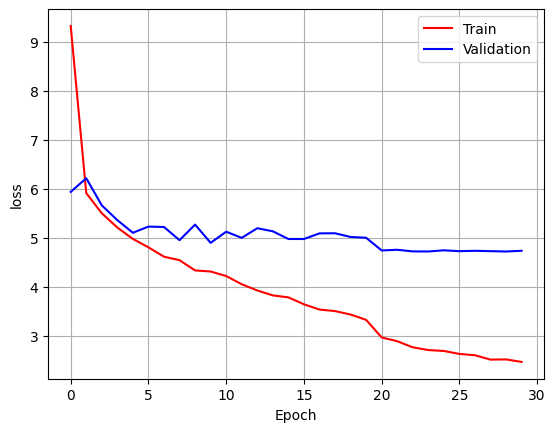

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
best_model_path = '/content/model.pt'
eval_model = torch.load('/content/model.pt')

eval_model.eval()

AgeEstimationModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
metric_test= evaluate(eval_model, test_loader, loss_fn)
metric_valid = evaluate(eval_model, valid_loader, loss_fn)

metric_test, metric_valid

((4.533016490029349,), (4.7237279483410095,))

# 🔴 **Inference**

🔰 your mission is to:

*   Write an inference function.
*   load an image from outside the UTKFace dataset
*   and evaluate the model's prediction.

In [ ]:
def inference(image_root:str, model):
  model.eval()

  input_eval_image = face_recognition.load_image_file(image_root)

  top, right, bottom, left = face_recognition.face_locations(input_eval_image)[0]

  cropped_image = input_eval_image[top:bottom, left:right]


  #transformed_eval_image = transform_test(Image.fromarray(cropped_img))

  with torch.no_grad():
    transformed_eval_image = transform_test(Image.fromarray(cropped_image)).unsqueeze(0)
    output = model(transformed_eval_image.to(device)).to(device)

  return output


33


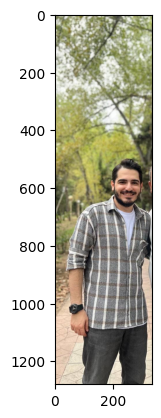

In [ ]:
my_bestmodel = torch.load('/content/model.pt')
image_root = '/content/imageforevaluate.jpg'

image = face_recognition.load_image_file(image_root)
pred = inference(image_root, model)[0][0]


print(int(pred))
plt.imshow(image);

24


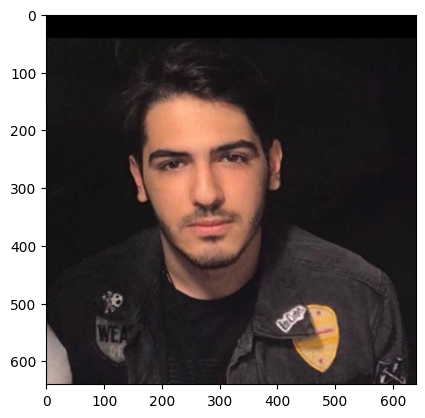

In [ ]:
#my_bestmodel = torch.load('/content/model.pt')
image_root = '/content/evalimage2.jpg'

image = face_recognition.load_image_file(image_root)
pred = inference(image_root, model)[0][0]


print(int(pred))
plt.imshow(image);

In [ ]:
#my_bestmodel = torch.load('/content/model.pt')
image_root = '/content/2449cf90-9041-4aa9-ab62-82bde3693be0.jpg'

image = face_recognition.load_image_file(image_root)
pred = inference(image_root, model)[0][0]


print(int(pred))
plt.imshow(image);

# 🔴 **Experiments**

## 🟠 Train and evaluate the model using various datasets.

## 🟠 Train the model using one dataset and then test it on a different one.

## 🟠 Analyze the loss value with respect to age, gender and race.

### Load best model as eval_model

In [ ]:
device

'cpu'

In [ ]:
eval_model = torch.load('/content/drive/MyDrive/trained/model.pt', map_location= torch.device('cpu'))

eval_model.eval()

AgeEstimationModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

### Calculate MAE for test_loader and add it to test data set as a new COL

In [ ]:
y_total, yp_total = [],[]


with torch.no_grad():
  for x, y,_,_ in test_loader:
    yp = eval_model(x.to(device)).to(device).squeeze()

    yp_total.append(yp)
    y_total.append(y)


yp_stacked = torch.cat(yp_total)
y_stacked = torch.cat(y_total)

print(yp_stacked.shape, y_stacked.shape)

torch.Size([3556]) torch.Size([3556])


In [ ]:
mae = yp_stacked.cpu().numpy()
eval_dataset = df_test

eval_dataset.insert(loc = len(eval_dataset.columns),column = "MAE", value = mae)

In [ ]:
eval_dataset.head()

,image_name,age,ethnicity,gender,MAE
14620,26_1_1_20170117134025403.jpg.chip.jpg,26.0,Black,Female,27.296761
10616,29_0_0_20170104235501676.jpg.chip.jpg,29.0,White,Male,33.647552
19521,40_0_0_20170117154612191.jpg.chip.jpg,40.0,White,Male,53.524822
12032,36_1_0_20170108224009217.jpg.chip.jpg,36.0,White,Female,32.892151
20363,24_0_3_20170119164640918.jpg.chip.jpg,24.0,Indian,Male,30.228521


### Analyze MAE (plotting)

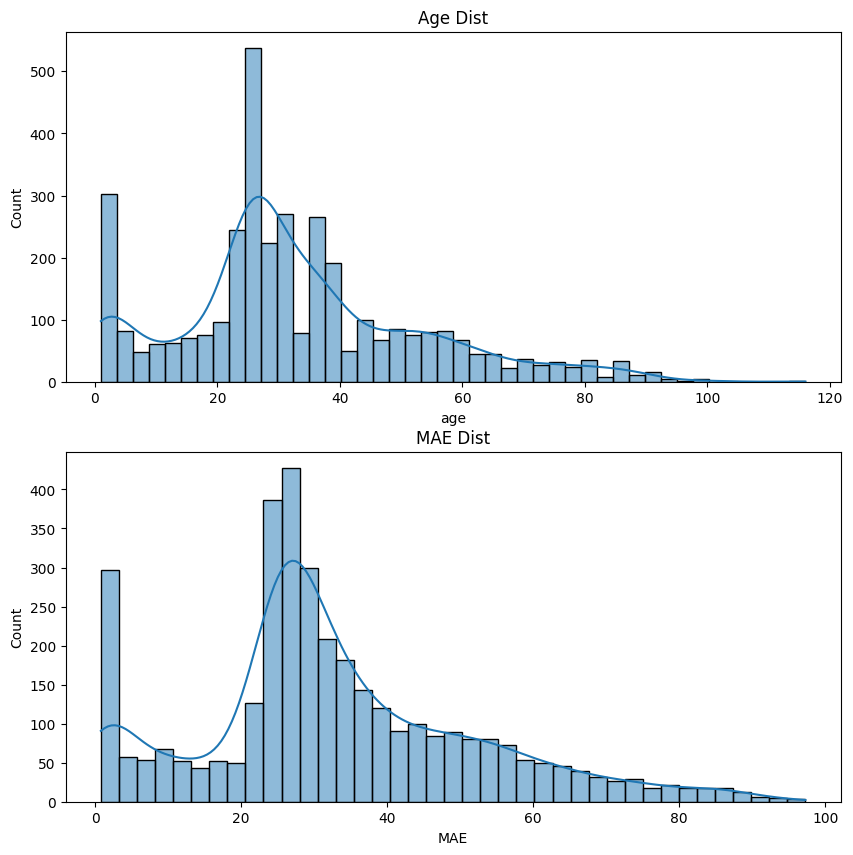

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.histplot(ax = axes[0], data = eval_dataset, x = 'age', kde = True); axes[0].set_title('Age Dist')
sns.histplot(ax = axes[1], data = eval_dataset, x = 'MAE', kde = True); axes[1].set_title('MAE Dist');

<Axes: xlabel='MAE', ylabel='Count'>

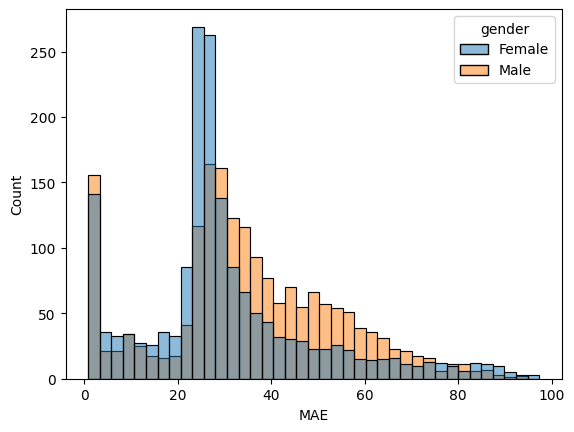

In [ ]:
sns.histplot(data=eval_dataset, x="MAE", hue = 'gender');

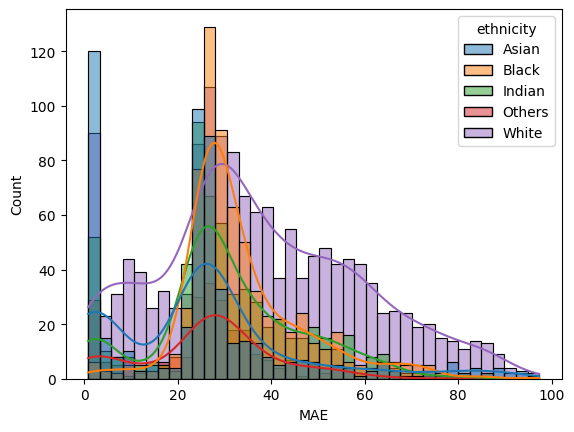

In [ ]:
sns.histplot(data=eval_dataset, x="MAE", hue = 'ethnicity', kde = True);

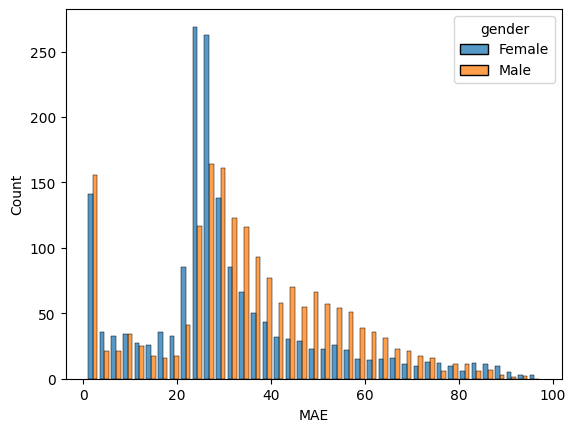

In [ ]:
sns.histplot(data=eval_dataset, x="MAE", hue="gender", multiple="dodge", shrink=.8);

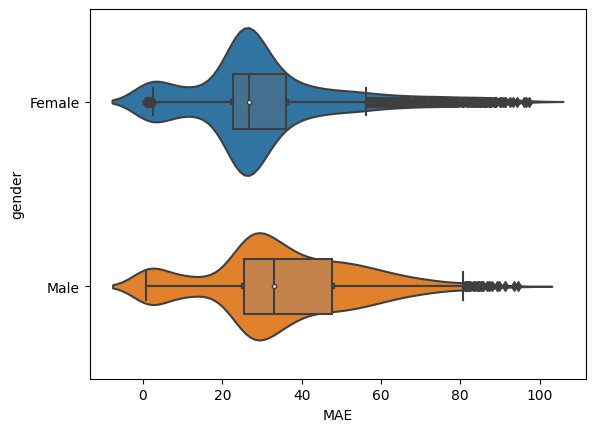

In [ ]:
ax = sns.violinplot(data = eval_dataset, x = 'MAE', y = 'gender')
sns.boxplot(data = eval_dataset, x = 'MAE', y = 'gender', saturation= 0.5, width= 0.3,
            boxprops={'zorder': 2}, ax=ax)
plt.show()

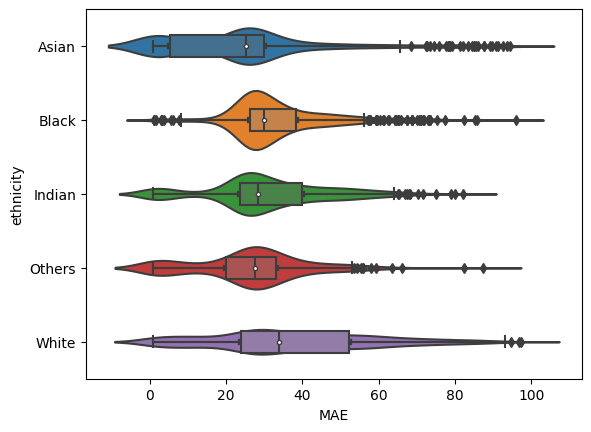

In [ ]:
ax = sns.violinplot(data = eval_dataset, x = 'MAE', y = 'ethnicity')
sns.boxplot(data = eval_dataset, x = 'MAE', y = 'ethnicity', saturation= 0.5, width= 0.3,
            boxprops={'zorder': 2}, ax=ax)
plt.show()

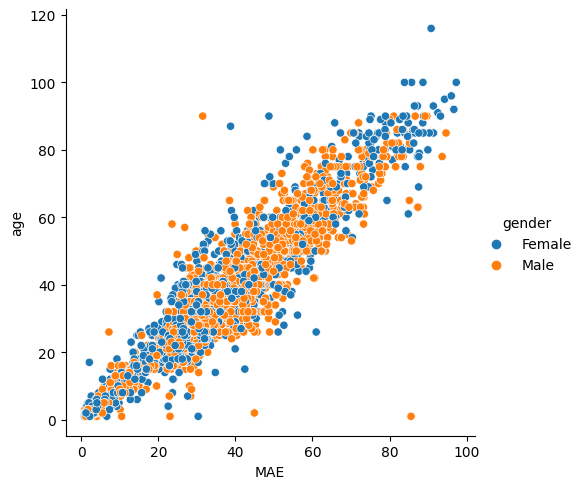

In [ ]:
sns.relplot(
    data=eval_dataset,
    x="MAE", y="age", hue="gender",)

### Analyze MAE (pandas functions)

In [ ]:
eval_dataset.groupby('ethnicity')['MAE'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian,536.0,25.204947,20.470156,0.802876,5.426433,25.285290,29.868890,94.269875
Black,679.0,33.727295,13.136786,1.063318,26.184996,29.841801,38.245600,96.026459
Indian,607.0,30.748796,15.793769,0.803715,23.597201,28.248535,39.828251,82.060020
Others,255.0,26.533371,15.046719,0.831905,19.988297,27.469492,33.181105,87.366386
White,1479.0,37.212254,21.519323,0.792996,23.900211,33.897751,52.145243,97.298660


In [ ]:
eval_dataset.groupby('gender')['MAE'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1716.0,30.328518,19.070381,0.818310,22.698172,26.683364,36.144404,97.298660
Male,1840.0,35.236080,18.973684,0.792996,25.497444,33.101517,47.665065,94.653465


## 🟠 Analyze the model's sensitivity.

24


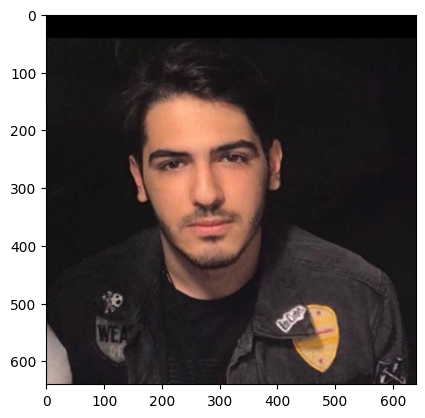

In [ ]:
image_root = '/content/evalimage2.jpg'

image = face_recognition.load_image_file(image_root)
pred = inference(image_root, eval_model)[0][0]


print(int(pred))
plt.imshow(image);

23


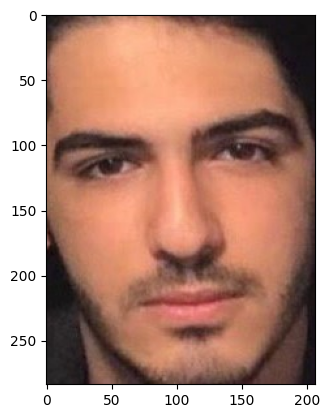

In [ ]:
image_root = '/content/evalimage2crop.jpg'

image = face_recognition.load_image_file(image_root)
pred = inference(image_root, eval_model)[0][0]


print(int(pred))
plt.imshow(image);

21


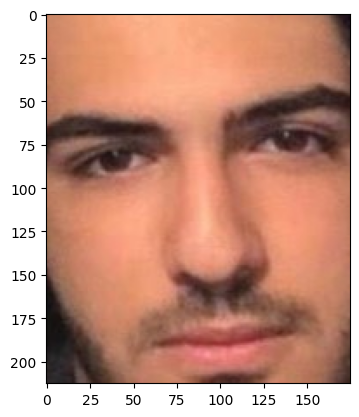

In [ ]:
image_root = '/content/evalimage2crop2.jpg'

image = face_recognition.load_image_file(image_root)
pred = inference(image_root, eval_model)[0][0]


print(int(pred))
plt.imshow(image);

## 🟠 Create a heatmap for the face images.

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from skimage.io import imread
from skimage.transform import resize

In [ ]:
eval_model.model[7]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}')
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [ ]:
backward_hook = eval_model.model[7].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = eval_model.model[7].register_forward_hook(forward_hook, prepend=False)

In [ ]:
from PIL import Image

img_path = "/content/evalimage2crop.jpg"
image = Image.open(img_path).convert('RGB')

In [ ]:
from torchvision import transforms
from torchvision.transforms import ToTensor


transform = transforms.Compose([transforms.Resize(size= (224,224)),
                                transforms.ToTensor()])


img_tensor = transform(image) # stores the tensor that represents the image

In [ ]:
# since we're feeding only one image, it is a 3d tensor (3, 256, 256).
# we need to unsqueeze to it has 4 dimensions (1, 3, 256, 256) as
# the model expects it to.
eval_model(img_tensor.unsqueeze(0).to(device)).backward()
# here we did the forward and the backward pass in one line.

In [ ]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

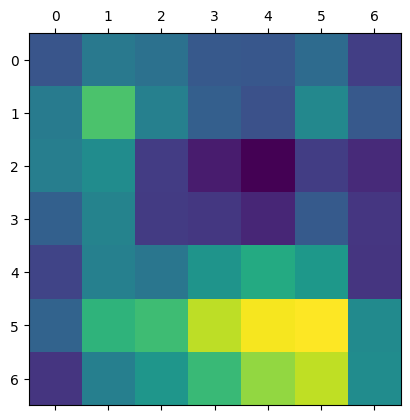

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach().cpu())

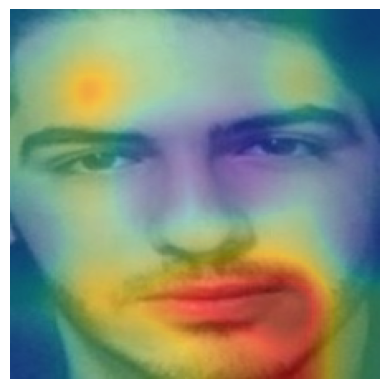

In [ ]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

# Create a figure and plot the first image
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

# First plot the original image
ax.imshow(to_pil_image(img_tensor, mode='RGB'))

# Resize the heatmap to the same size as the input image and defines
# a resample algorithm for increasing image resolution
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
overlay = to_pil_image(heatmap.detach(), mode='F').resize((224,224), resample=PIL.Image.BICUBIC)

# Apply any colormap you want
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes,
# but with alpha < 1 (this defines the transparency of the heatmap)
ax.imshow(overlay, alpha=0.4, interpolation='nearest')

# Show the plot
plt.show()

In [ ]:
backward_hook.remove()
forward_hook.remove()

# 🔴 **Use the model to perform age estimation on a webcam image.**

⛔️ You cannot perform this task using Jupyter Notebook or Google Colab. For this session, please use IDEs such as PyCharm or VSCode.